O objetivo deste trabalho é comparar diversos métodos de classificação para a base de dados de qualidade de vinhos disponível em https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv.

Vocês devem encontrar um bom modelo preditivo, variando:
* o número e conjunto de features (atributos) utilizados
* o método utilizado
* a configuração do algoritmo correspondente (e.g.: número k para nearest neighbors, profundidade para árvore de decisão)

Vocês devem listar algumas métricas de qualidade, tais como: precision, recall, accuracy e f1_score, e utilizar accuracy como base para a avaliação final, considerando a accuracy média de 10 iterações para cada configuração.

Para assegurar que eu obterei os mesmos resultados de vocês, vocês devem estabelecer a semente para a geração dos números aleatórios (utilizados para separar os conjuntos de treinamento e teste, por exemplo), utilizando os seguintes comandos no início do seu código (podem utilizar uma outra semente):
```
import random
random.seed(1001001)
```

In [1]:
import random
random.seed(1001001)
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import neighbors
import random
%matplotlib inline

In [2]:
df_vinho_vermelho = pd.read_csv('in/winequality-red.csv', sep = ';')
qtd_media_acc = 10
# Data source description:
# https://archive.ics.uci.edu/ml/datasets/Wine+Quality
#url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
# comment the next line if Internet access is available
#url = 'in.data/winequality-red.csv'
#df_vinho_vermelho = pd.read_csv(url)
df_vinho_vermelho.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
print(df_vinho_vermelho.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


(array([ 10.,   0.,  53.,   0., 681.,   0., 638.,   0., 199.,  18.]),
 array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ]),
 <a list of 10 Patch objects>)

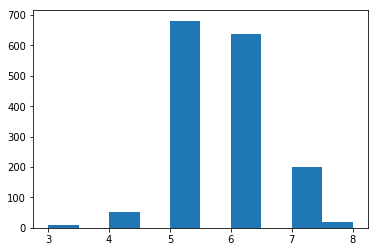

In [4]:
plt.hist(df_vinho_vermelho.quality)

/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_pred
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,5


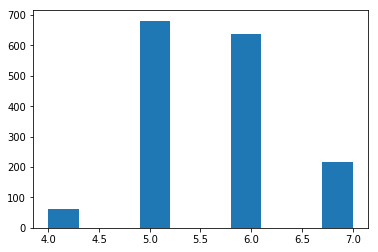

In [5]:
def AjustaQuality(df):
    df['quality_pred'] = df.quality.copy()
    for i in range(len(df)):
        if df.quality.iloc[i] == 3:
            df.quality_pred.iloc[i] = 4
        elif df.quality.iloc[i] == 8:
            df.quality_pred.iloc[i] = 7
            
    plt.hist(df.quality_pred)
    return df

df_vinho_vermelho = AjustaQuality(df_vinho_vermelho)

df_vinho_vermelho.head()

In [6]:
def descobre_correlacao(df):
    df = df.drop(['quality', 'quality_pred'], axis = 1)
    colunas = df.columns
    lst_corr = []
    linha_corr = []
    for c in colunas:
        for c2 in colunas:
            linha_corr.append(df[c].corr(df[c2]))
            if df[c].corr(df[c2]) > 0.6 and df[c].corr(df[c2]) < 0.99:
                print c,'----' ,c2, ' = ' ,df[c].corr(df[c2])
        lst_corr.append(linha_corr)
        linha_corr = []

    return pd.DataFrame(lst_corr, columns = colunas, index = colunas)
print('Tentando descobrir correlacao entre as colunas')
descobre_correlacao(df_vinho_vermelho)     
#print(df_vinho_vermelho.density.corr(df_vinho_vermelho.pH))

Tentando descobrir correlacao entre as colunas
fixed acidity ---- citric acid  =  0.671703434764106
fixed acidity ---- density  =  0.6680472921189744
citric acid ---- fixed acidity  =  0.671703434764106
free sulfur dioxide ---- total sulfur dioxide  =  0.6676664504810219
total sulfur dioxide ---- free sulfur dioxide  =  0.6676664504810219
density ---- fixed acidity  =  0.6680472921189744


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595


In [7]:
#retorna um conjuto de colunas aleatorio
def aletoriza_atributos(atributos):
    lst_att = []
    for i in range(random.randint(1, 4)):
        lst_att.append(atributos[random.randint(0, len(atributos)-1)])
    #print lst_att
    return lst_att
#aletoriza_atributos(df_vinho_vermelho.columns)

In [8]:
def defineXeY(df, drop_atributos, pred):
    drop_atributos.append('quality')
    drop_atributos.append('quality_pred')
    X = df_vinho_vermelho.drop(drop_atributos, axis = 1)
    sc = StandardScaler()
    X = sc.fit_transform(X)
    Y = df_vinho_vermelho[pred]
    return X, Y

('average accuracy in training data:', '0.7217')
('average accuracy in test data:    ', '0.6437')
             precision    recall  f1-score   support

          4       0.20      0.06      0.10        16
          5       0.63      0.84      0.72       129
          6       0.69      0.60      0.64       132
          7       0.65      0.40      0.49        43

avg / total       0.63      0.64      0.62       320



Text(0,0.5,u'Accuracy')

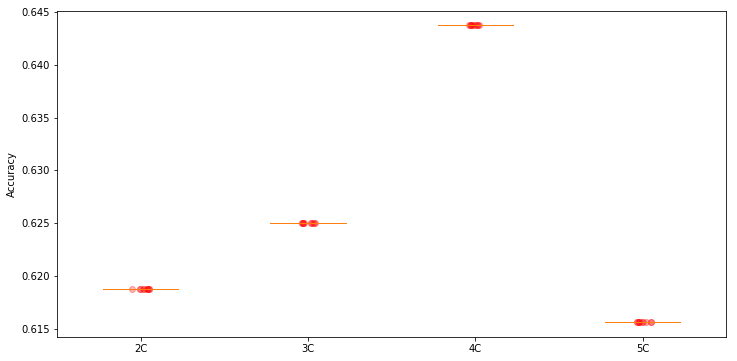

In [16]:
#roda o knc diversas vezes e depois retorna seus resultados
X, Y = defineXeY(df_vinho_vermelho,['fixed acidity'], 'quality_pred')
outcome_labels = Y.unique()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
def faz_aprendizado_knc(X_train, X_test, y_train, y_test, n):
    #Create an instance of K-nearest neighbor classifier
    knn_model = neighbors.KNeighborsClassifier(n_neighbors=n)
    knn_model.fit(X_train, y_train)
    KNeighborsClassifier_resultado = knn_model.predict(X_test)
    return classification_report(y_test, KNeighborsClassifier_resultado), confusion_matrix(y_test, KNeighborsClassifier_resultado), knn_model.score(X_train, y_train), knn_model.score(X_test, y_test)

def roda_knc(qtd_media_acc):
    acc_r=np.zeros((qtd_media_acc,4))
    
    #qtd_media_acc = qtd_media_acc + 10
    n = 0
    avg_accuracy_train = 0
    avg_accuracy_test = 0
    melhor_avg_accuracy_train = 0
    melhor_avg_accuracy_test = 0
    melhor_c_report = melhor_confm = melhor_accuracy_train = melhor_accuracy_test = 0
    for n_neighbors in range(2, 6): 
        avg_accuracy_train = 0
        avg_accuracy_test = 0
        for i in range(qtd_media_acc):
            c_report, confm, accuracy_train, accuracy_test = faz_aprendizado_knc(X_train, X_test, y_train, y_test, n_neighbors)
            
            acc_r[i][n_neighbors-2] = accuracy_test
            
            avg_accuracy_train = avg_accuracy_train + accuracy_train
            avg_accuracy_test = avg_accuracy_test + accuracy_test
            
            #print accuracy_test, accuracy_train
            if melhor_accuracy_test < accuracy_test:
                n = n_neighbors
                melhor_c_report = c_report
                melhor_confm = confm
                melhor_accuracy_train = accuracy_train
                melhor_accuracy_test = accuracy_test
                
        avg_accuracy_train = avg_accuracy_train/qtd_media_acc 
        avg_accuracy_test = avg_accuracy_test/qtd_media_acc
        if melhor_avg_accuracy_test < avg_accuracy_test:
            melhor_avg_accuracy_test =  avg_accuracy_test
            melhor_avg_accuracy_train = avg_accuracy_train
        
    #print('Melhor classificacao de teste tem %s centroids'%n)
    return melhor_c_report, melhor_confm, melhor_accuracy_train, melhor_accuracy_test, melhor_avg_accuracy_train, melhor_avg_accuracy_test, acc_r
c_report, confm, _,_, avg_accuracy_train, avg_accuracy_test, acc_r = roda_knc(qtd_media_acc)
#print(c_report, '\n\n')

print('average accuracy in training data:', '{:6.4f}'.format(avg_accuracy_train))
print('average accuracy in test data:    ', '{:6.4f}'.format(avg_accuracy_test))
confmT = confm.T
dfConfusionMatrix = pd.DataFrame(confmT)
dfConfusionMatrix.columns = ['true ' + str(val) for val in outcome_labels]
dfConfusionMatrix.index   = ['pred ' + str(val) for val in outcome_labels]
#print()
print(c_report)
dfConfusionMatrix

plt.figure(figsize=(12,6))
plt.boxplot(acc_r)
for i in range(4):
    xderiv = (i+1) * np.ones(acc_r[:,i].shape) + (np.random.rand(qtd_media_acc,)-0.5) * 0.1
    plt.plot(xderiv, acc_r[:,i], 'ro', alpha=0.3)
    
ax = plt.gca()
ax.set_xticklabels(['2C', '3C', '4C', '5C'])
plt.ylabel('Accuracy')

In [10]:
X, Y = defineXeY(df_vinho_vermelho,['total sulfur dioxide', 'density'], 'quality_pred')
outcome_labels = Y.unique()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

#roda o nb diversas vezes e depois retorna seus resultados
def faz_aprendizado_nb(X_train, X_test, y_train, y_test):
    GaussianNB_model = GaussianNB()
    GaussianNB_model.fit(X_train,y_train)
    GaussianNB_resultado = GaussianNB_model.predict(X_test)
    return classification_report(y_test, GaussianNB_resultado), confusion_matrix(y_test, GaussianNB_resultado), GaussianNB_model.score(X_train, y_train), GaussianNB_model.score(X_test, y_test)

def roda_nb(qtd_media_acc, mult):
    avg_accuracy_train = 0
    avg_accuracy_test = 0
    melhor_avg_accuracy_train = 0
    melhor_avg_accuracy_test = 0
    melhor_c_report = melhor_confm = melhor_accuracy_train = melhor_accuracy_test = 0
    if mult == True:
        for i in range(qtd_media_acc):
            c_report, confm, accuracy_train, accuracy_test = faz_aprendizado_nb(X_train, X_test, y_train, y_test)
            avg_accuracy_train = avg_accuracy_train + accuracy_train
            avg_accuracy_test = avg_accuracy_test + accuracy_test
            if melhor_accuracy_test < accuracy_test:
                melhor_c_report = c_report
                melhor_confm = confm
                melhor_accuracy_train = accuracy_train
                melhor_accuracy_test = accuracy_test


        avg_accuracy_train = avg_accuracy_train/qtd_media_acc 
        avg_accuracy_test = avg_accuracy_test/qtd_media_acc
        
        #print avg_accuracy_test
        if melhor_avg_accuracy_test < avg_accuracy_test:
            melhor_avg_accuracy_test =  avg_accuracy_test
            melhor_avg_accuracy_train = avg_accuracy_train
    else:
        melhor_c_report, melhor_confm, melhor_accuracy_train, melhor_accuracy_test = faz_aprendizado_nb(X_train, X_test, y_train, y_test)
        melhor_avg_accuracy_train = melhor_accuracy_train
        melhor_avg_accuracy_test = melhor_accuracy_test
        
    return melhor_c_report, melhor_confm, melhor_accuracy_train, melhor_accuracy_test, melhor_avg_accuracy_train, melhor_avg_accuracy_test

c_report, confm, _, _, avg_accuracy_train, avg_accuracy_test = roda_nb(qtd_media_acc, True)
#_, _, _, _, _, avg_accuracy_test = roda_nb(qtd_media_acc, True)


c_report, confm, avg_accuracy_train, avg_accuracy_test = faz_aprendizado_nb(X_train, X_test, y_train, y_test)
print('average accuracy in training data:', '{:6.4f}'.format(avg_accuracy_train))
print('average accuracy in test data:    ', '{:6.4f}'.format(avg_accuracy_test))
print(c_report)
confmT = confm.T
dfConfusionMatrix = pd.DataFrame(confmT)
dfConfusionMatrix.columns = ['true ' + str(val) for val in outcome_labels]
dfConfusionMatrix.index   = ['pred ' + str(val) for val in outcome_labels]
dfConfusionMatrix

('average accuracy in training data:', '0.5596')
('average accuracy in test data:    ', '0.5600')
             precision    recall  f1-score   support

          4       0.20      0.17      0.18        18
          5       0.72      0.64      0.67       162
          6       0.54      0.47      0.51       173
          7       0.40      0.77      0.53        47

avg / total       0.58      0.56      0.56       400



,true 5,true 6,true 7,true 4
pred 5,3,3,9,0
pred 6,6,103,33,2
pred 7,9,51,82,9
pred 4,0,5,49,36


In [11]:
X, Y = defineXeY(df_vinho_vermelho,['density'], 'quality_pred')
outcome_labels = Y.unique()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

#roda o dt diversas vezes e depois retorna seus resultados
def faz_aprendizado_dt(X_train, X_test, y_train, y_test):
    DecisionTreeClassifier_model = DecisionTreeClassifier()
    DecisionTreeClassifier_model.fit(X_train,y_train)
    DecisionTreeClassifier_resultado = DecisionTreeClassifier_model.predict(X_test)
    return classification_report(y_test, DecisionTreeClassifier_resultado), confusion_matrix(y_test, DecisionTreeClassifier_resultado), DecisionTreeClassifier_model.score(X_train, y_train), DecisionTreeClassifier_model.score(X_test, y_test)

def roda_dt(qtd_media_acc, mult):
    avg_accuracy_train = 0
    avg_accuracy_test = 0
    melhor_avg_accuracy_train = 0
    melhor_avg_accuracy_test = 0
    melhor_c_report = melhor_confm = melhor_accuracy_train = melhor_accuracy_test = 0
    if mult == True:
        for i in range(qtd_media_acc):
            c_report, confm, accuracy_train, accuracy_test = faz_aprendizado_dt(X_train, X_test, y_train, y_test)
            avg_accuracy_train = avg_accuracy_train + accuracy_train
            avg_accuracy_test = avg_accuracy_test + accuracy_test
            if melhor_accuracy_test < accuracy_test:
                melhor_c_report = c_report
                melhor_confm = confm
                melhor_accuracy_train = accuracy_train
                melhor_accuracy_test = accuracy_test


        avg_accuracy_train = avg_accuracy_train/qtd_media_acc 
        avg_accuracy_test = avg_accuracy_test/qtd_media_acc

        if melhor_avg_accuracy_test < avg_accuracy_test:
            melhor_avg_accuracy_test =  avg_accuracy_test
            melhor_avg_accuracy_train = avg_accuracy_train
    else:
        melhor_c_report, melhor_confm, melhor_accuracy_train, melhor_accuracy_test = faz_aprendizado_dt(X_train, X_test, y_train, y_test)
        melhor_avg_accuracy_train = melhor_accuracy_train
        melhor_avg_accuracy_test = melhor_accuracy_test
    return melhor_c_report, melhor_confm, melhor_accuracy_train, melhor_accuracy_test, melhor_avg_accuracy_train, melhor_avg_accuracy_test

c_report, confm, _, _, avg_accuracy_train, avg_accuracy_test = roda_dt(qtd_media_acc, True)
print('average accuracy in training data:', '{:6.4f}'.format(avg_accuracy_train))
print('average accuracy in test data:    ', '{:6.4f}'.format(avg_accuracy_test))
print(c_report)
confmT = confm.T
dfConfusionMatrix = pd.DataFrame(confmT)
dfConfusionMatrix.columns = ['true ' + str(val) for val in outcome_labels]
dfConfusionMatrix.index   = ['pred ' + str(val) for val in outcome_labels]
dfConfusionMatrix

('average accuracy in training data:', '1.0000')
('average accuracy in test data:    ', '0.6562')
             precision    recall  f1-score   support

          4       0.22      0.40      0.29         5
          5       0.75      0.71      0.73        58
          6       0.71      0.66      0.68        73
          7       0.57      0.67      0.62        24

avg / total       0.68      0.67      0.67       160



,true 5,true 6,true 7,true 4
pred 5,2,4,3,0
pred 6,3,41,11,0
pred 7,0,12,48,8
pred 4,0,1,11,16


In [12]:
X, Y = defineXeY(df_vinho_vermelho,['density', 'total sulfur dioxide'], 'quality_pred')
outcome_labels = Y.unique()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

#roda o lr diversas vezes e depois retorna seus resultados
def faz_aprendizado_lr(X_train, X_test, y_train, y_test):
    LogisticRegression_model = LogisticRegression()
    #print len(X_train), len(y_train)
    LogisticRegression_model.fit(X_train, y_train)
    LogisticRegression_resultado = LogisticRegression_model.predict(X_test)
    return classification_report(y_test, LogisticRegression_resultado), confusion_matrix(y_test, LogisticRegression_resultado), LogisticRegression_model.score(X_train, y_train), LogisticRegression_model.score(X_test, y_test)

def roda_lr(qtd_media_acc, mult):
    avg_accuracy_train = 0
    avg_accuracy_test = 0
    melhor_avg_accuracy_train = 0
    melhor_avg_accuracy_test = 0
    melhor_c_report = melhor_confm = melhor_accuracy_train = melhor_accuracy_test = 0
    if mult == True:
        for i in range(qtd_media_acc):
            c_report, confm, accuracy_train, accuracy_test = faz_aprendizado_lr(X_train, X_test, y_train, y_test)
            #print accuracy_test
            avg_accuracy_train = avg_accuracy_train + accuracy_train
            avg_accuracy_test = avg_accuracy_test + accuracy_test
            if melhor_accuracy_test < accuracy_test:
                melhor_c_report = c_report
                melhor_confm = confm
                melhor_accuracy_train = accuracy_train
                melhor_accuracy_test = accuracy_test


        avg_accuracy_train = avg_accuracy_train/qtd_media_acc 
        avg_accuracy_test = avg_accuracy_test/qtd_media_acc

        if melhor_avg_accuracy_test < avg_accuracy_test:
            melhor_avg_accuracy_test =  avg_accuracy_test
            melhor_avg_accuracy_train = avg_accuracy_train
    else:
        melhor_c_report, melhor_confm, melhor_accuracy_train, melhor_accuracy_test = faz_aprendizado_lr(X_train, X_test, y_train, y_test)
        melhor_avg_accuracy_train = melhor_accuracy_train
        melhor_avg_accuracy_test = melhor_accuracy_test
    return melhor_c_report, melhor_confm, melhor_accuracy_train, melhor_accuracy_test, melhor_avg_accuracy_train, melhor_avg_accuracy_test

c_report, confm, _, _, avg_accuracy_train, avg_accuracy_test = roda_lr(qtd_media_acc, False)

print('average accuracy in training data:', '{:6.4f}'.format(avg_accuracy_train))
print('average accuracy in test data:    ', '{:6.4f}'.format(avg_accuracy_test))
print(c_report)
confmT = confm.T
dfConfusionMatrix = pd.DataFrame(confmT)
dfConfusionMatrix.columns = ['true ' + str(val) for val in outcome_labels]
dfConfusionMatrix.index   = ['pred ' + str(val) for val in outcome_labels]
dfConfusionMatrix

('average accuracy in training data:', '0.5900')
('average accuracy in test data:    ', '0.6625')
             precision    recall  f1-score   support

          4       0.00      0.00      0.00         9
          5       0.70      0.69      0.69        67
          6       0.62      0.82      0.70        65
          7       0.88      0.37      0.52        19

avg / total       0.65      0.66      0.64       160



/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,true 5,true 6,true 7,true 4
pred 5,0,0,0,0
pred 6,8,46,11,1
pred 7,1,21,53,11
pred 4,0,0,1,7


In [13]:
X, Y = defineXeY(df_vinho_vermelho,[], 'quality_pred')
outcome_labels = Y.unique()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

#roda o svm diversas vezes e depois retorna seus resultados
def faz_aprendizado_svm(X_train, X_test, y_train, y_test):
    svc = SVC()
    svc.fit(X_train, y_train)
    SupportVectorMachines_resultado = svc.predict(X_test)
    return classification_report(y_test, SupportVectorMachines_resultado), confusion_matrix(y_test, SupportVectorMachines_resultado), svc.score(X_train, y_train), svc.score(X_test, y_test)

def roda_svm(qtd_media_acc, mult):
    avg_accuracy_train = 0
    avg_accuracy_test = 0
    melhor_avg_accuracy_train = 0
    melhor_avg_accuracy_test = 0
    melhor_c_report = melhor_confm = melhor_accuracy_train = melhor_accuracy_test = 0
    if mult == True:
        for i in range(qtd_media_acc):
            c_report, confm, accuracy_train, accuracy_test = faz_aprendizado_svm(X_train, X_test, y_train, y_test)
            #print accuracy_test
            avg_accuracy_train = avg_accuracy_train + accuracy_train
            avg_accuracy_test = avg_accuracy_test + accuracy_test
            if melhor_accuracy_test < accuracy_test:
                melhor_c_report = c_report
                melhor_confm = confm
                melhor_accuracy_train = accuracy_train
                melhor_accuracy_test = accuracy_test


        avg_accuracy_train = avg_accuracy_train/qtd_media_acc 
        avg_accuracy_test = avg_accuracy_test/qtd_media_acc

        if melhor_avg_accuracy_test < avg_accuracy_test:
            melhor_avg_accuracy_test =  avg_accuracy_test
            melhor_avg_accuracy_train = avg_accuracy_train
    else:
        melhor_c_report, melhor_confm, melhor_accuracy_train, melhor_accuracy_test = faz_aprendizado_svm(X_train, X_test, y_train, y_test)
        melhor_avg_accuracy_train = melhor_accuracy_train
        melhor_avg_accuracy_test = melhor_accuracy_test
    return melhor_c_report, melhor_confm, melhor_accuracy_train, melhor_accuracy_test, melhor_avg_accuracy_train, melhor_avg_accuracy_test

c_report, confm, _, _, avg_accuracy_train, avg_accuracy_test = roda_svm(qtd_media_acc, False)

print('average accuracy in training data:', '{:6.4f}'.format(avg_accuracy_train))
print('average accuracy in test data:    ', '{:6.4f}'.format(avg_accuracy_test))
print(c_report)
confmT = confm.T
dfConfusionMatrix = pd.DataFrame(confmT)
dfConfusionMatrix.columns = ['true ' + str(val) for val in outcome_labels]
dfConfusionMatrix.index   = ['pred ' + str(val) for val in outcome_labels]
dfConfusionMatrix

('average accuracy in training data:', '0.6724')
('average accuracy in test data:    ', '0.6687')
             precision    recall  f1-score   support

          4       0.00      0.00      0.00         9
          5       0.72      0.84      0.77       135
          6       0.63      0.68      0.65       134
          7       0.59      0.24      0.34        42

avg / total       0.64      0.67      0.64       320



,true 5,true 6,true 7,true 4
pred 5,0,0,1,0
pred 6,7,113,35,3
pred 7,2,22,91,29
pred 4,0,0,7,10


('average accuracy in training data:', '1.0000')
('average accuracy in test data:    ', '0.6978')
             precision    recall  f1-score   support

          4       1.00      0.20      0.33         5
          5       0.81      0.76      0.79       143
          6       0.63      0.77      0.69       124
          7       0.71      0.52      0.60        48

avg / total       0.73      0.72      0.72       320



Text(0,0.5,u'Accuracy')

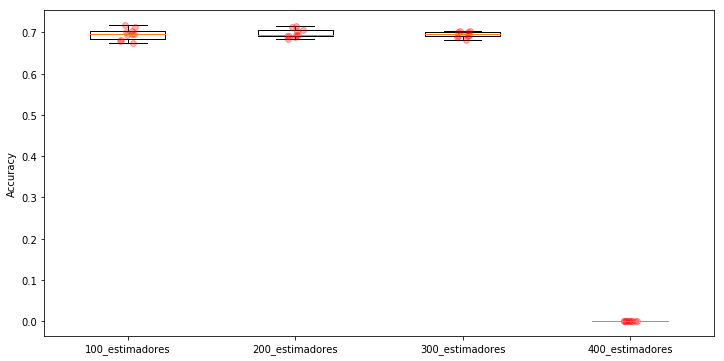

In [18]:
X, Y = defineXeY(df_vinho_vermelho,['density'], 'quality_pred')
outcome_labels = Y.unique()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

#roda o rfc diversas vezes e depois retorna seus resultados

def faz_aprendizado_rfc(X_train, X_test, y_train, y_test, qtd_estimators):
    RandomForestClassifier_model = RandomForestClassifier(n_estimators = qtd_estimators)
    RandomForestClassifier_model.fit(X_train, y_train)
    RandomForestClassifier_resultado = RandomForestClassifier_model.predict(X_test)
    return classification_report(y_test, RandomForestClassifier_resultado) , confusion_matrix(y_test, RandomForestClassifier_resultado), RandomForestClassifier_model.score(X_train, y_train), RandomForestClassifier_model.score(X_test, y_test)

def roda_rfc(qtd_media_acc):
    n = 0
    acc_r=np.zeros((qtd_media_acc,4))
    
    avg_accuracy_train = 0
    avg_accuracy_test = 0
    melhor_avg_accuracy_train = 0
    melhor_avg_accuracy_test = 0
    melhor_c_report = melhor_confm = melhor_accuracy_train = melhor_accuracy_test = 0
    for qtd_estimators in range(1, 4): 
        avg_accuracy_train = 0
        avg_accuracy_test = 0
        for i in range(qtd_media_acc):
            c_report, confm, accuracy_train, accuracy_test = faz_aprendizado_rfc(X_train, X_test, y_train, y_test, qtd_estimators*100)
            acc_r[i][qtd_estimators - 1] = accuracy_test
            avg_accuracy_train = avg_accuracy_train + accuracy_train
            avg_accuracy_test = avg_accuracy_test + accuracy_test
            if melhor_accuracy_test < accuracy_test:
                n = qtd_estimators
                melhor_c_report = c_report
                melhor_confm = confm
                melhor_accuracy_train = accuracy_train
                melhor_accuracy_test = accuracy_test
                
        avg_accuracy_train = avg_accuracy_train/qtd_media_acc 
        avg_accuracy_test = avg_accuracy_test/qtd_media_acc
        if melhor_avg_accuracy_test < avg_accuracy_test:
            melhor_avg_accuracy_test =  avg_accuracy_test
            melhor_avg_accuracy_train = avg_accuracy_train
    #print('Melhor classificacao de teste tem %s qtd_estimators'%(n*100))
    return melhor_c_report, melhor_confm, melhor_accuracy_train, melhor_accuracy_test, melhor_avg_accuracy_train, melhor_avg_accuracy_test, acc_r

c_report, confm, _,_, avg_accuracy_train, avg_accuracy_test, acc_r = roda_rfc(qtd_media_acc)
print('average accuracy in training data:', '{:6.4f}'.format(avg_accuracy_train))
print('average accuracy in test data:    ', '{:6.4f}'.format(avg_accuracy_test))
print(c_report)
confmT = confm.T
dfConfusionMatrix = pd.DataFrame(confmT)
dfConfusionMatrix.columns = ['true ' + str(val) for val in outcome_labels]
dfConfusionMatrix.index   = ['pred ' + str(val) for val in outcome_labels]
dfConfusionMatrix

plt.figure(figsize=(12,6))
plt.boxplot(acc_r)
for i in range(4):
    xderiv = (i+1) * np.ones(acc_r[:,i].shape) + (np.random.rand(qtd_media_acc,)-0.5) * 0.1
    plt.plot(xderiv, acc_r[:,i], 'ro', alpha=0.3)
    
ax = plt.gca()
ax.set_xticklabels(['100_estimadores', '200_estimadores', '300_estimadores', '400_estimadores'])
plt.ylabel('Accuracy')

('Colunas dropadas para teste de modelo', ['alcohol', 'pH'])
[[0.5875    0.528125  0.653125  0.6       0.63125   0.69375  ]
 [0.5875    0.528125  0.6565625 0.6       0.63125   0.703125 ]
 [0.5875    0.528125  0.6515625 0.6       0.63125   0.7      ]
 [0.5875    0.528125  0.6521875 0.6       0.63125   0.709375 ]
 [0.5875    0.528125  0.650625  0.6       0.63125   0.709375 ]
 [0.5875    0.528125  0.656875  0.6       0.63125   0.709375 ]
 [0.5875    0.528125  0.6528125 0.6       0.63125   0.696875 ]
 [0.5875    0.528125  0.65125   0.6       0.63125   0.70625  ]
 [0.5875    0.528125  0.64875   0.6       0.63125   0.70625  ]
 [0.5875    0.528125  0.661875  0.6       0.63125   0.703125 ]]


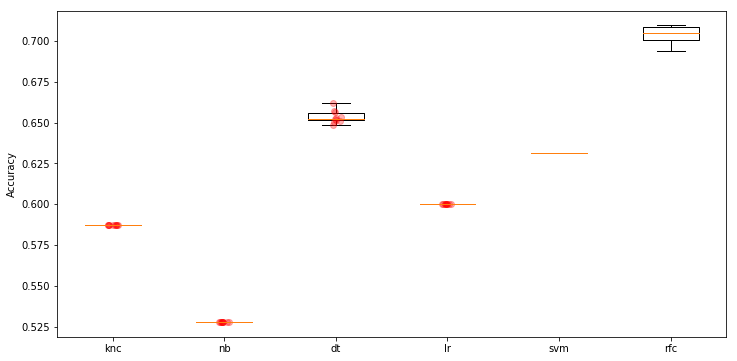

In [19]:
#Essa uma combinacao aleatoria de features e depois mostra os resultados da accuracia para descobrir qual combinacao de features gera o melhor resultado

def descobre_features(df):
    drop_atributos = aletoriza_atributos(df.columns)  
    print('Colunas dropadas para teste de modelo', drop_atributos)
    acc_r=np.zeros((qtd_media_acc,6))
    
    for i in range(qtd_media_acc):
        X, Y = defineXeY(df, drop_atributos, 'quality_pred')
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
        _, _, _,_, _, acc_r[i][0], _ = roda_knc(1)
        
        X, Y = defineXeY(df, drop_atributos, 'quality_pred')
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
        _, _, _, _, _, acc_r[i][1] = roda_nb(1, True)
        
        X, Y = defineXeY(df, drop_atributos, 'quality_pred')
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
        _, _, _,_, _, acc_r[i][2] = roda_dt(qtd_media_acc, True)
        
        X, Y = defineXeY(df, drop_atributos, 'quality_pred')
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
        _, _, _,_, _, acc_r[i][3] = roda_lr(1, True)
        
        X, Y = defineXeY(df, drop_atributos, 'quality_pred')
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
        _, _, _,_, _, acc_r[i][4] = roda_svm(1, True)
        
        X, Y = defineXeY(df, drop_atributos, 'quality_pred')
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
        _, _, _,_, _, acc_r[i][5], _ = roda_rfc(1)
        

    print(acc_r)
    plt.figure(figsize=(12,6))
    plt.boxplot(acc_r)
    for i in range(4):
        xderiv = (i+1) * np.ones(acc_r[:,i].shape) + (np.random.rand(10,)-0.5) * 0.1
        plt.plot(xderiv, acc_r[:,i], 'ro', alpha=0.3)
    
    ax = plt.gca()
    ax.set_xticklabels(['knc', 'nb', 'dt', 'lr', 'svm', 'rfc'])
    plt.ylabel('Accuracy')
    return
        
descobre_features(df_vinho_vermelho)  
#['density', 'free sulfur dioxide', 'fixed acidity', 'alcohol'] ->[0.56875  0.565625 0.66875  0.590625 0.625    0.73125 ]]